## Titanic Problem:
#### Learning linear regression with tensor flow and using it to predict whether a passenger of the titanic will survive

Initializing the libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow import feature_column as fc
import tensorflow as tf

Getting the Data from csv files into Pandas DataFrame. We need train data and test data, to make sure our models are correct. The survival data is extracted to different DataFrames.

In [47]:
dftrain = pd.read_csv('Dataset/train.csv') # training data
dfeval = pd.read_csv('Dataset/eval.csv') # testing data

y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

Just plotting the data for me to see.

<Axes: ylabel='sex'>

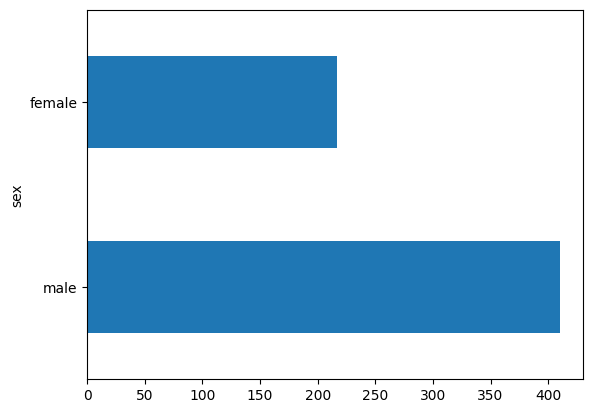

In [48]:
dftrain.sex.value_counts().plot(kind='barh')

Our data has catagorical data like town or deck and others. Computers don't care about catagorical data. So we need to convert it to numerical data, as computers only care if there is a difference between the data. Feature columns are what we use to send the data to tensor. Here we create two for loops to add the numerical and catagorical data to our feature columns.

In [49]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))


In [50]:
print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

To train the data, with large data sets, we can not give all the data at the same time. So we give the data to the model in batches. So like 32 data sets at a time.
Another important thing is that we can't just give the data to the training model once, because our model will not be that good. So we use epochs to give the data to the model in different ways so the model gets different percpectives and pick up patterns. Sometimes we can give the data too much to the model, so it just memorizes our data points and is bad at predicting data points outside our training data. So we start with less ecpochs and increase them when we need to.

We need to use input functions to define how our data is going to be broken into epochs and batches before it is fed to our model. We need to turn the dataset which is a pandas dataframe, and turn it into a tensorflow dataset.
We don't actually return the data set but, return the function that will return the dataset(I will look into this more lator). The function we return first uses `tf.data.Dataset` to create the dataset (`ds`) object. Then we shuffle the items in it and split it into batch sizes we defined and epochs we need. `Apparantly this type of input functions are outdated and i need to look into the new tendorflow 2 version`

In [95]:
def make_input_fn(data_df, label_df, num_epochs=25, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs

    return ds  # return a batch of the dataset
  return input_function  # return a function object for use
train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


Create a linear estimator which is used to train the mode. Don't know what a linear estimator is and how it works. So ... look into that.

In [96]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier
clear_output()

Created the training model, it gives an accuracy of 74%, which is bad. But if you change the number of epochs to 20 instead of 10 it gives an accuracy of 78%. I think it is because you get many more different percpectives on the data which makes it easier to find patterns in the data. But if i increase the number of epochs to like 100 it still gives 100, so I think thats just how accurate we can get with this amount of data. Even at 2000! LMAO it gives 78, so I think there really is a limit to what the model can get with this limited amount of data.

In [97]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data
clear_output()
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.780303


Usining .pridict to check the survival chances of our model. For example, for the third person, our model predicts that the person has a 58% chance of survival, but we know that they survived, so our pridiction is kinda stinky.

sex                        female
age                          55.0
n_siblings_spouses              0
parch                           0
fare                         16.0
class                      Second
deck                      unknown
embark_town           Southampton
alone                           y
Name: 3, dtype: object
1
0.5850893


<Axes: title={'center': 'predicted probabilities'}, ylabel='Frequency'>

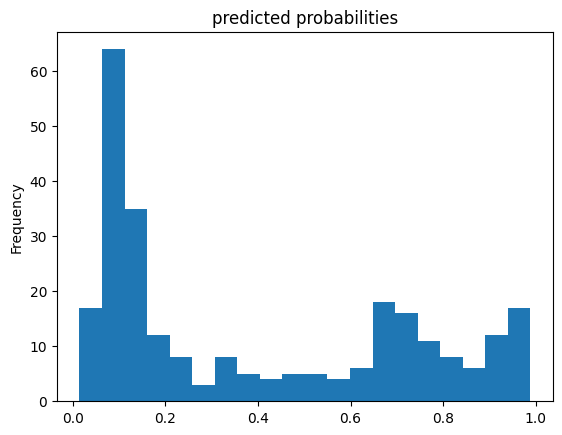

In [109]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
clear_output()
print(dfeval.loc[3])
print(y_eval.loc[3])
print(pred_dicts[3]['probabilities'][1])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

## Done, linear regression. WOOOOOOOOOOOOOOOOO. Time to do Clasification.